# Import Statements

In [1]:
import numpy as np
import pandas as pd
import math
import cmath
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

import scipy
from scipy import signal

import watermark 

# Data Setup for Geo Sim

In [2]:
# File from Luke
samples = np.fromfile(r"C:\Users\henry\Documents\PythonScripts\DoaNN_old\Rand16Q_255", np.complex64) # Read in file.  We have to tell it what format it is

test = np.array(samples)
print(test.shape)

(1000000,)


In [3]:
# Setup for the geometry simulator

# Calculate speed of light to be used in calculating time delay
eps0 = 8.854187817e-12
mu0 = 4*np.pi * 1e-7
c0 = 1/np.sqrt(eps0*mu0)

# Frequencies to be used
fs = 20000000  # sampling frequency
fs1 = 2.45e9  # transmitting frequency
lambda1 = c0/fs1  # Wavelength of transmitting frequency

# Generate RX geometry location
RX = np.zeros(2) 
RX[1] = 0  # Middle RX element y-location
RX[0] = RX[1] + lambda1/2  # Location of top RX element

# Antenna Geometry
horz_elements = 2 # horizontal antenna elements (rows)
vert_elements = 1 # vertical antenna elements (col)
num_elements = horz_elements * vert_elements # number of antenna elements

# creating blank arrays to store the values from the geometry simulator
elements = [[], []] # empty matrix to store each elements data
angleofArrival = [] # empty matrix to store DoA
print(elements) # examples of indexing elements[0][0] = 1, elements[1][2] = 3 

[[], []]


In [ ]:
# instead of taking samples from luke make array of all ones
# 

In [4]:
# Reducing the amount of samples from the file from Luke
N = 512 # size of the sample, fft size, 512 and 1000 seemed to give good values
aveN = 1000 # averaging the sigal

small_samples = np.zeros(N, complex) # blank array to store the data

# taking samples and reducing the length and getting the data setup for averaging
Tsamples = np.zeros((aveN,N),dtype=complex)
for k in range(aveN):
    for i in range(N):
        Tsamples[k,i] = samples[i+N*k]

# print(small_samples.shape)

# Geo Sim

In [5]:
# Generating the Data for the NN
numberofSamples = 100

for i in range(numberofSamples):
    TX = randint(-100, 100) # Generate TX geometry location, y-location
    L = randint(100, 500) # X-distance between TX and RX

    # Calculate angles
    angle = np.zeros(2)
    angle[0] = np.arctan((TX-RX[0])/L)  # Angle seen at top RX element
    angle[1] = np.arctan((TX-RX[1])/L)  # Angle seen at middle RX element

    angle = np.rad2deg(angle) # Convert from radians to degrees

    # Calculate Distances 
    D = np.zeros(2) # blank distance array
    D = np.sqrt(L**2+(TX-RX)**2) # distance in [m]

    # Calculate time delays for each element [s]
    td = np.zeros(2) # blank time delay array
    td[0] = D[0]/c0 # time delay for element 1
    td[1] = D[1]/c0 # time delay for element 2

    mintd = np.min(td) # finding the min time delay
    totaltd = td - mintd # setting the mind time delay to 0
    
    #FFT and shift magnitude
    fTsamples = np.zeros((aveN,N),dtype=complex)
    for k in range(aveN):
        fTsamples[k,:] = np.fft.fft(Tsamples[k,:],n=N)
        fTsamples[k,:] = np.fft.fftshift(fTsamples[k,:])
    
    # converting the signal into the frequency domain
#     fsmall_samples = np.fft.fft(small_samples)
#     fsmall_samples = np.fft.fftshift(fsmall_samples)
    
    fstemp = 2.44e9

    # Create frequency array around fs1
    fs1 = np.linspace(fstemp-fs/2,fstemp+fs/2,num=N)
    
    # shifting the signal in the frequency domain
    
    shift0 = np.zeros((aveN,N),dtype=complex)
    shift1 = np.zeros((aveN,N),dtype=complex)
    
    for i in range(aveN):
        shift0[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[0])
        shift1[i,:] = fTsamples[i,:]*np.exp(-1j*2*np.pi*fs*totaltd[1])

        shift0[i,:] = np.fft.ifftshift(shift0[i,:])
        shift1[i,:] = np.fft.ifftshift(shift1[i,:])

        # converting from frequency domain back to time domain
        shift0[i,:] = np.fft.ifft(shift0[i,:])
        shift1[i,:] = np.fft.ifft(shift1[i,:])
    
    # storing the data
    elements[0].append(shift0) # storing the data for element 1
    elements[1].append(shift1) # storing the data for element 2 
    angleofArrival.append(angle[0]) # storing the AoA
    # End for loop

# checking time delay and angles
print(totaltd)
print(angle)

[0.00000000e+00 2.64103213e-11]
[7.42574092 7.44532485]


# Verifying Geo Sim Output

In [6]:
# checking the shape and values for element 1
element1 = np.array(elements[0]) 
print(element1.shape)

# checking the shape and values for elements
testEle1 = np.array(elements)
print(testEle1.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(100, 1000, 512)
(2, 100, 1000, 512)


In [7]:
# checking the shape and values for element 1
element1 = np.array(elements[1])
print(element1.shape)

# checking the shape and values for elements
testEle2 = np.array(elements)
print(testEle2.shape)
# 10 is the time aveN

# for i in element1:
#     print(i)

(100, 1000, 512)
(2, 100, 1000, 512)


In [8]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)

# for i in angleofArrival:
#     print(i)

(100,)


# Cross Correlation

In [9]:
# Data setup for the correlation and averaging
element1 = np.array(elements[0]) # (number of DoA senarios, aveN, number of samples from signal)
element2 = np.array(elements[1])

test = np.array(element1[0])
print(element1.shape)
print(test.shape)

(100, 1000, 512)
(1000, 512)


In [10]:
# corr each time step then take the mean
corr = []  # creating a blank array to store the correlations in
avg = []

# Loops through the number of samples
for n in range(numberofSamples):
    # taking the (numberofSamples, aveN, Samples) to (aveN, Samples)
    temp1 = np.array(element1[n])
    temp2 = np.array(element2[n])

    # zero matrix to store the correlations between samples
    S_all = np.zeros(N, dtype=complex)

    # Loops through the aveN
    for i in range(aveN):
        # takes the correlation between element#(n, i, samples)
        temp = signal.correlate(temp1[i], temp2[i], mode='same', method='auto')
        S_all += temp
        
    # averag the magnitudes
    avg.append(S_all/aveN)
        
corr = avg

test = np.array(corr)
print(test.shape)

(100, 512)


# Correlation Output

C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\henry\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-23-dca25eec8a3c>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


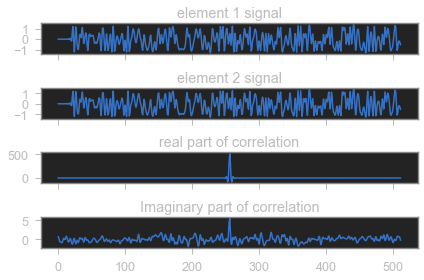

In [23]:
# Plotting the real part of the correlation
corrREAL = np.real(np.array(corr)) # 1&2
corrIMAG = np.imag(np.array(corr)) # 1&2

# Plotting the correlation to make sure it looks correct before moving on
fig, (ax_signal1, ax_signal2, ax_corrREAL, ax_corrIMAG) = plt.subplots(4, 1, sharex=True)

# picking a random index to sample from
# sample = randint(0,numberofSamples-1)
sample = 6

# Element 1
ax_signal1.plot(element1[sample][0])
ax_signal1.set_title('element 1 signal')

# Element 2
ax_signal2.plot(element2[sample][0])
ax_signal2.set_title('element 2 signal')

# cross correlation between element 1 and 2, real part
ax_corrREAL.plot(corrREAL[sample])
ax_corrREAL.set_title('real part of correlation')

# cross correlation between element 1 and 2, imag part
ax_corrIMAG.plot(corrIMAG[sample])
ax_corrIMAG.set_title('Imaginary part of correlation')

fig.tight_layout()
fig.show()

In [20]:
# checking the shape and values for DoA
ANGLE = np.array(angleofArrival)
print(ANGLE.shape)

for i in angleofArrival:
    print(i)

(100,)
9.296837949758766
-12.322153795195673
12.465657194873193
4.937212415928446
-9.13342135230588
-2.8391972561135606
24.71096765056211
-7.549726332931129
0.8604655611654393
-5.888235895678667
16.180667326938615
-10.57270271446329
6.5615017167333125
-31.77671692971934
-1.9959902234009486
0.6859175036649762
11.250214360307782
-8.26364266829972
-13.664814712549395
22.829574291480164
-5.255606263262702
-8.584299989992054
4.042214267048149
20.690333319207156
-5.190052534718796
5.3299627182128075
6.947920368773948
18.185766612387553
8.056560580795386
14.33719121571729
19.208550990444863
-8.831543813562412
-9.692709447786962
-7.206752255176292
3.0244948287583955
-1.568477286150069
-3.275109178751295
-30.433873601373406
7.408815683727305
10.917834229010369
-3.3870095832626204
3.69562567774263
-1.7895217706543871
15.836605400195422
-12.942427402176595
20.621973519925707
-0.6221375697984194
-30.989525148930554
-2.053223210814481
29.06753751588244
19.690001288141993
-6.623040622160075
-1.32801

# Complex to polar

In [13]:
# Concatinating the real and imag parts of the correlation
realCorr = np.real(np.array(corr))
imagCorr = np.imag(np.array(corr))

# combing the real and imaginary values [real,imag]
complexCorr = np.concatenate((realCorr,imagCorr),axis=-1)
print(complexCorr.shape)

(100, 1024)


In [14]:
# Converting to polar from complex
tempCorr = np.array(corr)
print(tempCorr.shape)

polarCorr = np.concatenate((tempCorr, np.zeros((numberofSamples, N))), axis=-1)
print(polarCorr.shape)

for j in range(numberofSamples):
    for i in range(N):
        temp = abs(tempCorr[j][i])
        temp2 = cmath.phase(tempCorr[j][i])
        polarCorr[j][i] = float(temp)
        polarCorr[j][N+i] = temp2

print('--------------------')
print(polarCorr.shape)
print(polarCorr[0].shape)

(100, 512)
(100, 1024)
--------------------
(100, 1024)
(1024,)


In [15]:
for i in range(10):
    print(np.real(polarCorr[0][i]))

0.7268195477589711
0.22448925468643263
0.8966882760802503
0.8986859038856095
0.7100074881693935
0.9421424329232372
0.7787255410216086
0.25980010964800193
0.4476799798816624
0.25069505108825074


In [16]:
for i in range(256,266):
    print(np.real(polarCorr[0][i]))

512.6582512893077
316.36615014071396
1.1571739898853566
82.24053521773966
1.230153560426115
30.09906609746244
0.6803896389385775
6.603290176464464
0.7013734478135035
1.3619178052571763


In [17]:
for i in range(10):
    print(np.real(polarCorr[1][i]))

0.7268195477589708
0.22448925468643302
0.8966882760802511
0.8986859038856096
0.7100074881693935
0.9421424329232382
0.7787255410216078
0.2598001096480023
0.44767997988166275
0.25069505108825013


In [18]:
for i in range(256,266):
    print(np.real(polarCorr[1][i]))

512.6582512893083
316.36615014071384
1.1571739898853557
82.24053521773969
1.2301535604261173
30.099066097462426
0.6803896389385764
6.603290176464448
0.7013734478135046
1.3619178052571763


In [19]:
for i in angleofArrival:
    print(i)

9.296837949758766
-12.322153795195673
12.465657194873193
4.937212415928446
-9.13342135230588
-2.8391972561135606
24.71096765056211
-7.549726332931129
0.8604655611654393
-5.888235895678667
16.180667326938615
-10.57270271446329
6.5615017167333125
-31.77671692971934
-1.9959902234009486
0.6859175036649762
11.250214360307782
-8.26364266829972
-13.664814712549395
22.829574291480164
-5.255606263262702
-8.584299989992054
4.042214267048149
20.690333319207156
-5.190052534718796
5.3299627182128075
6.947920368773948
18.185766612387553
8.056560580795386
14.33719121571729
19.208550990444863
-8.831543813562412
-9.692709447786962
-7.206752255176292
3.0244948287583955
-1.568477286150069
-3.275109178751295
-30.433873601373406
7.408815683727305
10.917834229010369
-3.3870095832626204
3.69562567774263
-1.7895217706543871
15.836605400195422
-12.942427402176595
20.621973519925707
-0.6221375697984194
-30.989525148930554
-2.053223210814481
29.06753751588244
19.690001288141993
-6.623040622160075
-1.328018520130

# New heading